In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

verbose_print = True

def log(*args, **kwargs):
    if verbose_print:
        print("LOG:", *args, **kwargs)

np.random.seed(42)

In [2]:
def load_csv(path):
    full = os.path.join('diabetes', path)
    return pd.read_csv(full)

df_immutable = load_csv('fav_ds.csv')


def features_response(df):
    return df.drop('readmitted', axis=1), df['readmitted']

def fresh_copy():
    return df_immutable.copy()

def fresh_dfs():
    return features_response(fresh_copy())
    
pd.set_option('display.max_columns', None)

print(df_immutable.info())
df_immutable.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7831 entries, 0 to 7830
Columns: 170 entries, age to readmitted
dtypes: float64(1), int64(168), object(1)
memory usage: 10.2+ MB
None


,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,weight_present,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_25,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_17,admission_source_id_20,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_bamboozled,gender_Male,medical_specialty_Emergency/Trauma,medical_specialty_Endocrinology,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology/Oncology,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Otolaryngology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-Endocrinology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_Psychiatry,medical_specialty_Psychiatry-Child/Adolescent,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiology,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-General,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Thoracic,medical_specialty_Urology,medical_specialty_bamboozled,diag_1_Congenital Anomalies,diag_1_Diseases of the Blood and Blood-forming Organs,diag_1_Diseases of the Circulatory System,diag_1_Diseases of the Digestive System,diag_1_Diseases of the Genitourinary System,diag_1_Diseases of the Musculoskeletal System and Connective Tissue,diag_1_Diseases of the Nervous System and Sense Organs,diag_1_Diseases of the Respiratory System,diag_1_Diseases of the Skin and Subcutaneous Tissue,"diag_1_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",diag_1_Infectious and Parasitic Diseases,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Neoplasms,diag_1_None,diag_1_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"diag_1_Symptoms, Signs and Ill-defined Conditions",diag_2_Congenital Anomalies,diag_2_Diseases of the Blood and Blood-forming Organs,diag_2_Diseases of the Circulatory System,diag_2_Diseases of the Digestive System,diag_2_Diseases of the Genitourinary System,diag_2_Diseases of the Musculoskeletal System and Connective Tissue,diag_2_Diseases of the Nervous System and Sense Organs,diag_2_Diseases of the Respiratory System,diag_2_Diseases of the Skin and Subcutaneous Tissue,"diag_2_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",diag_2_Infectious and Parasitic Diseases,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Neoplasms,diag_2_None,diag_2_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"diag_2_Symptoms, Signs and Ill-defined Conditions",diag_2_injury and poisoning,diag_3_Congenital Anomalies,diag_3_Diseases of the Blood and Blood-forming Organs,diag_3_Diseases of the Circulatory System,diag_3_Diseases of the Digestive System,diag_3_Diseases of the Genitourinary System,diag_3_Diseases of the Musculoskeletal System and Connective Tissue,diag_3_Diseases of the Nervous System and Sense Organs,diag_3_Diseases of the Respiratory System,diag_3_Diseases of the Skin an

In [3]:
def process_df(df, labels):
    # Split into train and test
    
    X_all, y_all = df.values, labels.values
    feature_names = df.columns

    X_all = StandardScaler().fit_transform(X_all)

    sss = StratifiedShuffleSplit(n_splits=1, random_state=42)
    train_full_idx, test_idx = next(sss.split(X_all, y_all))

    X_train_full, y_train_full = X_all[train_full_idx], y_all[train_full_idx]
    X_test, y_test = X_all[test_idx], y_all[test_idx]

    # Further split train into train and validation
    sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)

    train_idx, dev_idx = next(sss.split(X_train_full, y_train_full))
    X_train, y_train = X_train_full[train_idx], y_train_full[train_idx]
    X_dev, y_dev = X_train_full[dev_idx], y_train_full[dev_idx]

    log(f"Shape of train: {X_train.shape}, {y_train.shape}")
    log(f"Shape of dev: {X_dev.shape}, {y_train.shape}")
    log(f"Shape of test: {X_test.shape}, {y_test.shape}")
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

def fresh_sets():
    df, labels = fresh_dfs()
    return process_df(df, labels)

def self_acc(model, X, y):
    log("Calculating accuracy on the test data...")
    model.fit(X, y)
    pred = model.predict(X)
    
    acc = accuracy_score(y, pred)
    
    log(f"Accuracy on the test data is {acc}")

def cv_acc(model, cv=5):
    
    X_train, y_train, X_dev, y_dev, X_test, y_test = fresh_sets()
    
    full_X = np.concatenate((X_train, X_test))
    full_y = np.concatenate((y_train, y_test))
    
    log(f"Model {model}")
    
    self_acc(model, full_X, full_y)
    
    start = time.time()
    acc = np.mean(cross_val_score(model, full_X, full_y, cv=cv))
    log(f"Cross val score: {acc}")
    
    elapsed = time.time() - start
    log(f"Mean elapsed for each cv: {elapsed/cv}\n")
    
    return acc

In [4]:
X_train, y_train, X_dev, y_dev, X_test, y_test = fresh_sets()

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)


In [7]:
rf_fav = RandomForestClassifier(random_state=42, n_estimators=300, max_leaf_nodes=300, n_jobs=3)
cv_acc(rf_fav)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=300,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.7737112599283601
LOG: Cross val score: 0.5355912767631268
LOG: Mean elapsed for each cv: 1.072187852859497



0.5355912767631268

In [18]:
accs = []

for comp in range(1, X_train.shape[1], 20):
    pca = PCA()
    
    X_train_less = pca.fit_transform(X_train)[:, :comp]
    X_dev_less = pca.transform(X_dev)[:, :comp]
    
    rf_fav.fit(X_train_less, y_train)
    pred = rf_fav.predict(X_dev_less)
    
    acc = accuracy_score(pred, y_dev)
    accs.append((comp, acc))
    log(f"Trying with {comp} components got acc {acc}")

accs = np.array(accs)
accs

LOG: Trying with 1 components got acc 0.3617021276595745
LOG: Trying with 21 components got acc 0.46808510638297873
LOG: Trying with 41 components got acc 0.474468085106383
LOG: Trying with 61 components got acc 0.48865248226950353
LOG: Trying with 81 components got acc 0.4851063829787234
LOG: Trying with 101 components got acc 0.48014184397163123
LOG: Trying with 121 components got acc 0.47304964539007094
LOG: Trying with 141 components got acc 0.48439716312056735
LOG: Trying with 161 components got acc 0.4929078014184397


array([[  1.        ,   0.36170213],
       [ 21.        ,   0.46808511],
       [ 41.        ,   0.47446809],
       [ 61.        ,   0.48865248],
       [ 81.        ,   0.48510638],
       [101.        ,   0.48014184],
       [121.        ,   0.47304965],
       [141.        ,   0.48439716],
       [161.        ,   0.4929078 ]])

In [19]:

pca = PCA()

comp = X_train.shape[1]

X_train_less = pca.fit_transform(X_train)[:, :comp]
X_dev_less = pca.transform(X_dev)[:, :comp]

rf_fav.fit(X_train_less, y_train)
pred = rf_fav.predict(X_dev_less)

acc = accuracy_score(pred, y_dev)
log(f"Trying with {comp} components got acc {acc}")

LOG: Trying with 169 components got acc 0.4971631205673759


In [28]:
accs = np.concatenate((accs, [[comp, acc]]))
accs

array([[  1.        ,   0.36170213],
       [ 21.        ,   0.46808511],
       [ 41.        ,   0.47446809],
       [ 61.        ,   0.48865248],
       [ 81.        ,   0.48510638],
       [101.        ,   0.48014184],
       [121.        ,   0.47304965],
       [141.        ,   0.48439716],
       [161.        ,   0.4929078 ],
       [169.        ,   0.49716312]])

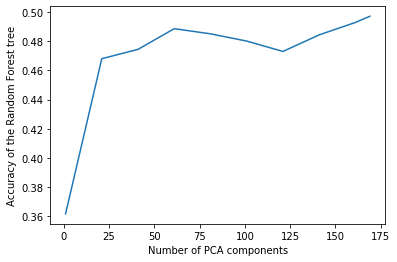

In [31]:
plt.plot(accs[:, 0], accs[:, 1])
plt.xlabel("Number of PCA components")
plt.ylabel("Accuracy of the Random Forest tree")
plt.savefig("pca-rf.png")

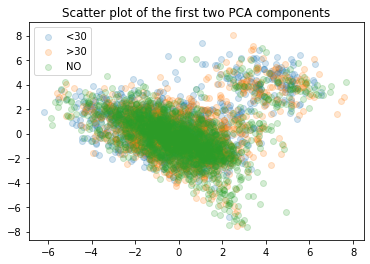

In [34]:
X_train_2 = pca_components(X_train, 2)

for cls in np.unique(y_train):
    idx = (y_train == cls)
    
    plt.scatter(X_train_2[idx, 0], X_train_2[idx, 1], label=cls, alpha=0.2)
plt.legend()
plt.title('Scatter plot of the first two PCA components')
plt.savefig('pca-scatter.png')